In [1]:
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from datasets import load_dataset
import evaluate
from torch.utils.data import DataLoader
from tqdm.auto import tqdm
import time
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
# =======================================================
# 步骤 1: 统一配置
# =======================================================

# --- 1. 配置 ---
# --- 新增: Bert-Large Baseline 模型路径 ---
BASELINE_FP32_LARGE_MODEL_PATH = "./bert-large-sst2-finetuned/checkpoint-300/"

# 输入模型：你已经剪枝并微调好的16层FP32模型
PRUNED_FP32_MODEL_PATH = "./models/bert_pruned_16_layers_finetuned/best_model"

# 输出模型：我们将要创建并保存的FP16模型
PRUNED_FP16_MODEL_SAVE_PATH = "./models/bert_pruned_16L_fp16_gpu"

# 分词器名称
TOKENIZER_NAME = "bert-large-uncased"

TEST_SENTENCE = "This movie is not bad at all, in fact it is surprisingly good!"
LATENCY_RUNS = 100
EVAL_BATCH_SIZE = 32
FIGURE_DIR = "./figure" # 图表保存目录

# 确保GPU可用
if not torch.cuda.is_available():
    raise RuntimeError("This experiment requires a GPU!")
DEVICE = torch.device("cuda")

print("Configuration set. Using GPU for conversion and evaluation.")
os.makedirs(PRUNED_FP16_MODEL_SAVE_PATH, exist_ok=True)
os.makedirs(FIGURE_DIR, exist_ok=True)

Configuration set. Using GPU for conversion and evaluation.


In [3]:
# =======================================================
# 步骤 2: FP16模型转换与保存 (逻辑不变)
# =======================================================
print(f"Loading FP32 model from: {PRUNED_FP32_MODEL_PATH}")
model_fp16 = AutoModelForSequenceClassification.from_pretrained(
    PRUNED_FP32_MODEL_PATH,
    torch_dtype=torch.float16
).to(DEVICE)

# 加载对应的分词器用于保存
tokenizer_to_save = AutoTokenizer.from_pretrained(PRUNED_FP32_MODEL_PATH)

print(f"Saving FP16 model to: {PRUNED_FP16_MODEL_SAVE_PATH}")
model_fp16.save_pretrained(PRUNED_FP16_MODEL_SAVE_PATH)
tokenizer_to_save.save_pretrained(PRUNED_FP16_MODEL_SAVE_PATH)
print("FP16 model conversion and saving complete.")

# 清理内存
del model_fp16, tokenizer_to_save
torch.cuda.empty_cache()

Loading FP32 model from: ./models/bert_pruned_16_layers_finetuned/best_model
Saving FP16 model to: ./models/bert_pruned_16L_fp16_gpu
FP16 model conversion and saving complete.


In [4]:
# =======================================================
# 步骤 3: 辅助函数 (逻辑不变)
# =======================================================
def get_model_size(path):
    total_size = 0
    for dirpath, _, filenames in os.walk(path):
        for f in filenames:
            fp = os.path.join(dirpath, f)
            total_size += os.path.getsize(fp)
    return total_size / (1024 * 1024)

def measure_latency(model, tokenizer, device):
    inputs = tokenizer(TEST_SENTENCE, return_tensors="pt").to(device)
    timings = []
    with torch.no_grad():
        for _ in range(20): _ = model(**inputs)
        for _ in range(LATENCY_RUNS):
            torch.cuda.synchronize()
            start_time = time.perf_counter()
            _ = model(**inputs)
            torch.cuda.synchronize()
            end_time = time.perf_counter()
            timings.append(end_time - start_time)
    return np.mean(timings) * 1000

def evaluate_accuracy(model, tokenizer, device, eval_dataloader):
    metric = evaluate.load("accuracy")
    model.eval()
    for batch in tqdm(eval_dataloader, desc=f"Evaluating Accuracy"):
        batch = {k: v.to(device) for k, v in batch.items() if k in ['input_ids', 'attention_mask', 'labels']}
        with torch.no_grad():
            outputs = model(input_ids=batch['input_ids'], attention_mask=batch['attention_mask'])
        predictions = torch.argmax(outputs.logits, dim=-1)
        metric.add_batch(predictions=predictions, references=batch["labels"])
    return metric.compute()["accuracy"]

In [5]:
# =======================================================
# 步骤 4: 数据准备 (统一加载分词器)
# =======================================================
print("Preparing dataset for evaluation...")
# --- 修改点 1: 在这里统一加载分词器，供所有后续步骤使用 ---
tokenizer = AutoTokenizer.from_pretrained(TOKENIZER_NAME)

raw_datasets = load_dataset("glue", "sst2")
def tokenize_function(examples):
    return tokenizer(examples["sentence"], padding="max_length", truncation=True, max_length=128)
tokenized_datasets = raw_datasets.map(tokenize_function, batched=True)
tokenized_datasets = tokenized_datasets.remove_columns(['sentence', 'idx'])
tokenized_datasets = tokenized_datasets.rename_column("label", "labels") # 确保列名为 'labels'
tokenized_datasets.set_format('torch')
eval_dataset = tokenized_datasets["validation"]
eval_dataloader = DataLoader(eval_dataset, batch_size=EVAL_BATCH_SIZE)
print("Dataset ready.")

Preparing dataset for evaluation...


Map:   0%|          | 0/67349 [00:00<?, ? examples/s]

Map:   0%|          | 0/872 [00:00<?, ? examples/s]

Map:   0%|          | 0/1821 [00:00<?, ? examples/s]

Dataset ready.


In [6]:
# =======================================================
# 步骤 5: 性能对比评估 (加入Baseline)
# =======================================================
results = []
# --- 修改点 2: 更新对比列表，加入Baseline模型 ---
# bert-large-uncased 原始为24层
models_to_compare = [
    {"name": "1. FP32 Baseline (24L)", "path": BASELINE_FP32_LARGE_MODEL_PATH, "dtype": torch.float32},
    {"name": "2. Pruned FP32 (16L)", "path": PRUNED_FP32_MODEL_PATH, "dtype": torch.float32},
    {"name": "3. Pruned FP16 (16L, GPU-Only)", "path": PRUNED_FP16_MODEL_SAVE_PATH, "dtype": torch.float16}
]

for config in models_to_compare:
    print(f"\n{'='*20} EVALUATING: {config['name']} {'='*20}")
    current_results = {"Model": config['name']}
    current_results["Size (MB)"] = get_model_size(config['path'])
    
    model = AutoModelForSequenceClassification.from_pretrained(config['path'], torch_dtype=config['dtype']).to(DEVICE)
    # --- 修改点 3: 移除循环内的分词器加载，使用全局的tokenizer ---
    
    torch.cuda.reset_peak_memory_stats(DEVICE)
    inputs_for_mem = tokenizer(TEST_SENTENCE, return_tensors="pt").to(DEVICE)
    with torch.no_grad():
        _ = model(**inputs_for_mem)
    peak_mem_mb = torch.cuda.max_memory_allocated(DEVICE) / (1024 * 1024)
    current_results["Peak GPU Mem (MB)"] = peak_mem_mb
    
    current_results["Latency (GPU, ms)"] = measure_latency(model, tokenizer, DEVICE)
    current_results["Accuracy (GPU)"] = evaluate_accuracy(model, tokenizer, DEVICE, eval_dataloader)
    
    results.append(current_results)
    del model
    torch.cuda.empty_cache()

print(f"\n{'='*25} FINAL RESULTS {'='*25}")
df = pd.DataFrame(results)
for col in ["Size (MB)", "Peak GPU Mem (MB)", "Latency (GPU, ms)"]:
    df[col] = df[col].map('{:.2f}'.format)
df["Accuracy (GPU)"] = df["Accuracy (GPU)"].map('{:.4f}'.format)
print(df.to_markdown(index=False))


==================== EVALUATING: 1. FP32 Baseline (24L) ====================


Evaluating Accuracy:   0%|          | 0/28 [00:00<?, ?it/s]


==================== EVALUATING: 2. Pruned FP32 (16L) ====================


Evaluating Accuracy:   0%|          | 0/28 [00:00<?, ?it/s]


==================== EVALUATING: 3. Pruned FP16 (16L, GPU-Only) ====================


Evaluating Accuracy:   0%|          | 0/28 [00:00<?, ?it/s]


========================= FINAL RESULTS =========================
| Model                          |   Size (MB) |   Peak GPU Mem (MB) |   Latency (GPU, ms) |   Accuracy (GPU) |
|:-------------------------------|------------:|--------------------:|--------------------:|-----------------:|
| 1. FP32 Baseline (24L)         |     3836.7  |             1288.91 |                6.25 |           0.9312 |
| 2. Pruned FP32 (16L)           |      895    |              904.51 |                4.19 |           0.9392 |
| 3. Pruned FP16 (16L, GPU-Only) |      447.97 |              456.82 |                4.53 |           0.9392 |



========================= BATCH LATENCY VS THROUGHPUT TEST =========================

--- Testing Model: 1. FP32 Baseline (24L) ---
  Batch Size:  1 | Latency: 6.10 ms
  Batch Size:  2 | Latency: 6.30 ms
  Batch Size:  4 | Latency: 6.46 ms
  Batch Size:  8 | Latency: 6.64 ms
  Batch Size: 16 | Latency: 10.61 ms
  Batch Size: 32 | Latency: 13.52 ms

--- Testing Model: 2. Pruned FP32 (16L) ---
  Batch Size:  1 | Latency: 4.19 ms
  Batch Size:  2 | Latency: 4.32 ms
  Batch Size:  4 | Latency: 4.40 ms
  Batch Size:  8 | Latency: 4.49 ms
  Batch Size: 16 | Latency: 7.12 ms
  Batch Size: 32 | Latency: 9.10 ms

--- Testing Model: 3. Pruned FP16 (16L, GPU-Only) ---
  Batch Size:  1 | Latency: 4.36 ms
  Batch Size:  2 | Latency: 4.38 ms
  Batch Size:  4 | Latency: 4.35 ms
  Batch Size:  8 | Latency: 4.35 ms
  Batch Size: 16 | Latency: 4.33 ms
  Batch Size: 32 | Latency: 4.20 ms

--- Latency Comparison Table ---
| Model                          |   Batch Size |   Latency (ms) |
|:--------------

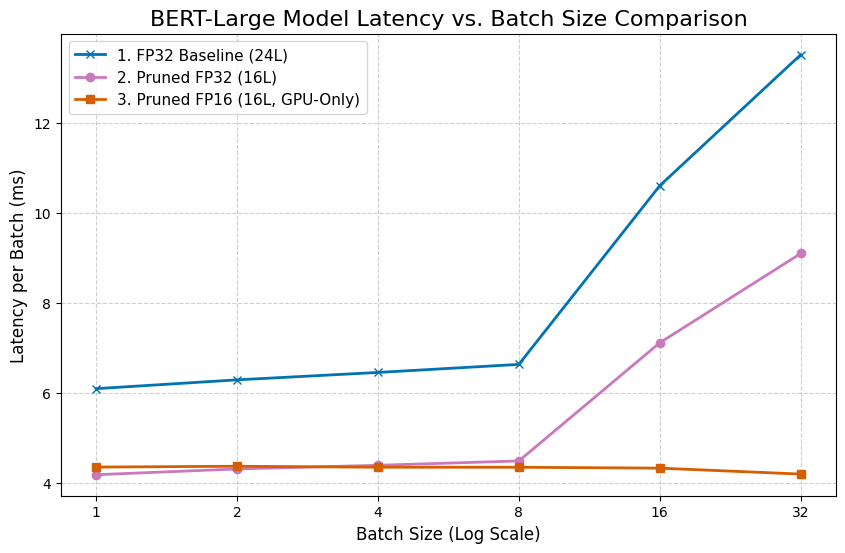

In [7]:
# ==============================================================================
# 步骤 6: 批量延迟测试与可视化 (已重构)
# ==============================================================================
print(f"\n{'='*25} BATCH LATENCY VS THROUGHPUT TEST {'='*25}")

BATCH_SIZES = [1, 2, 4, 8, 16, 32] # 对于Large模型，64可能导致OOM，可酌情调整
WARMUP_RUNS = 20
LATENCY_RUNS_BATCH = 100

# --- 修改点 4: 定义包含绘图信息在内的三个模型配置，并应用指定配色方案 ---
models_for_latency_test = [
    {
        "name": "1. FP32 Baseline (24L)",
        "path": BASELINE_FP32_LARGE_MODEL_PATH,
        "dtype": torch.float32,
        "color": '#0173B2',
        "marker": 'x'
    },
    {
        "name": "2. Pruned FP32 (16L)",
        "path": PRUNED_FP32_MODEL_PATH,
        "dtype": torch.float32,
        "color": '#CC78BC',
        "marker": 'o'
    },
    {
        "name": "3. Pruned FP16 (16L, GPU-Only)",
        "path": PRUNED_FP16_MODEL_SAVE_PATH,
        "dtype": torch.float16,
        "color": '#D55E00',
        "marker": 's'
    }
]

latency_results = []
test_sentences = [TEST_SENTENCE] * max(BATCH_SIZES)

# --- 修改点 5: 重构测试循环，确保每次只加载一个模型，并释放缓存 ---
for model_config in models_for_latency_test:
    print(f"\n--- Testing Model: {model_config['name']} ---")
    
    model = AutoModelForSequenceClassification.from_pretrained(
        model_config['path'], 
        torch_dtype=model_config['dtype']
    ).to(DEVICE).eval()

    for bs in BATCH_SIZES:
        inputs = tokenizer(test_sentences[:bs], return_tensors="pt", padding=True).to(DEVICE)
        
        timings = []
        with torch.no_grad():
            for _ in range(WARMUP_RUNS): _ = model(**inputs)
            for _ in range(LATENCY_RUNS_BATCH):
                torch.cuda.synchronize()
                start = time.perf_counter()
                _ = model(**inputs)
                torch.cuda.synchronize()
                end = time.perf_counter()
                timings.append(end - start)
        
        latency_ms = np.mean(timings) * 1000
        print(f"  Batch Size: {bs:2d} | Latency: {latency_ms:.2f} ms")
        
        latency_results.append({
            "Model": model_config['name'],
            "Batch Size": bs,
            "Latency (ms)": latency_ms
        })

    del model
    torch.cuda.empty_cache()

# --- 准备可视化数据 ---
df_latency = pd.DataFrame(latency_results)
print("\n--- Latency Comparison Table ---")
print(df_latency.to_markdown(index=False))

# --- 修改点 6: 循环绘图，动态应用配置 ---
plt.figure(figsize=(10, 6))

for model_config in models_for_latency_test:
    model_name = model_config['name']
    subset_df = df_latency[df_latency["Model"] == model_name]
    plt.plot(
        subset_df["Batch Size"], 
        subset_df["Latency (ms)"], 
        marker=model_config['marker'], 
        label=model_name, 
        color=model_config['color'], 
        linewidth=2
    )

# 更新图表元素
plt.xlabel("Batch Size (Log Scale)", fontsize=12)
plt.ylabel("Latency per Batch (ms)", fontsize=12)
plt.title("BERT-Large Model Latency vs. Batch Size Comparison", fontsize=16)
plt.legend(fontsize=11)
plt.grid(True, linestyle='--', alpha=0.6)
plt.xscale('log', base=2)
plt.xticks(BATCH_SIZES, BATCH_SIZES)

# 保存图表
output_filename = 'large_model_latency_comparison.svg'
plt.savefig(os.path.join(FIGURE_DIR, output_filename), format='svg', bbox_inches='tight', transparent=True)
print(f"\n图表已保存为可编辑的SVG文件: {os.path.join(FIGURE_DIR, output_filename)}")

# 显示图表
plt.show()